In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(1, '../metadl/baselines/sentive_ai')
from sentive.sentive_vision_network import sentive_vision_network

from sentive.sentive_brain import sentive_brain

root_ep = 'episode_'
suf_eptest = '_1.csv'
root_test= 'test_'

episode = np.zeros([1,5,28,28,2])
test = np.zeros([5, 28,28,2])
for i in range(5):
    episode[0][i][:,:,0] = np.loadtxt(root_ep+str(i)+suf_eptest)
    episode[0][i][:,:,1] = np.loadtxt(root_ep+str(i)+suf_eptest)

    test[i][:,:,0] = np.loadtxt(root_test+str(i)+suf_eptest)
    test[i][:,:,1] = np.loadtxt(root_test+str(i)+suf_eptest)


nombre de neurones taille 1: 47
sub_pxl_map
nb neurones couche 2 : 46
nombre de neurones couche 1 & 2: 94
taille neurones à séquencer : 47
taille neurones à séquencer : 8
taille neurones à séquencer : 0
found possible connexion on nrn id 76 : {72, 73, 80, 76}
Recherche des nœuds suivants [72] [76]
Commence la découpe de segmented_path [48, 50, 51, 53, 54, 55, 61, 60, 59, 58, 64, 65, 66, 69, 74, 77, 82, 87, 90, 91, 92, 93, 94, 89, 85, 80, 76, 73]
ratio_pxls_total nrn _ID 97 ,  0.8723404255319149
Fin de la découpe de segmented_path [72, 73]
ratio_pxls_total nrn _ID 98 ,  0.1276595744680851
nombre de neurones couches 1, 2 et 3 : 97
****************************************
SELECTED SEGMENTS [95, 96]
nombre de neurones taille 1: 74


/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = 

/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = 

nb neurones couche 2 : 73
nombre de neurones couche 1 & 2: 148
taille neurones à séquencer : 74
taille neurones à séquencer : 14
taille neurones à séquencer : 5
taille neurones à séquencer : 0
found possible connexion on nrn id 121 : {139, 118, 120, 121, 122}
found possible connexion on nrn id 112 : {97, 98, 99, 111, 112, 113, 115}
Recherche des nœuds suivants [139, 99] [121, 112]
Commence la découpe de segmented_path [79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 110, 111, 112, 115, 116, 118, 121, 120, 119, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123]
ratio_pxls_total nrn _ID 152 ,  0.5135135135135135
ratio_pxls_total nrn _ID 153 ,  0.25675675675675674
Fin de la découpe de segmented_path [139, 120, 119, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123]
ratio_pxls_total nrn _ID 154 ,  0.3108108108108108
nombre de neurones couches 1, 2 et 3 : 153
****************************************
SELECTED SEGMENTS [149, 

/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = 

 [123, 124, 125]
nombre de neurones taille 1: 65
nb neurones couche 2 : 64
nombre de neurones couche 1 & 2: 130
taille neurones à séquencer : 65
taille neurones à séquencer : 8
taille neurones à séquencer : 1
found possible connexion on nrn id 89 : {84, 85, 86, 88, 89, 90, 92, 93}
Recherche des nœuds suivants [85] [89]
Commence la découpe de segmented_path [119, 116, 114, 112, 110, 108, 106, 104, 102, 99, 96, 92, 89, 86, 81, 74, 71, 75, 82, 87, 91, 94, 98, 100, 103, 105, 107, 109, 111, 113, 115, 117, 124, 123, 122, 121, 120, 128, 127, 126]
ratio_pxls_total nrn _ID 133 ,  0.36923076923076925
Fin de la découpe de segmented_path [85, 86, 81, 74, 71, 75, 82, 87, 91, 94, 98, 100, 103, 105, 107, 109, 111, 113, 115, 117, 124, 123, 122, 121, 120, 128, 127, 126]
ratio_pxls_total nrn _ID 134 ,  0.676923076923077
nombre de neurones couches 1, 2 et 3 : 133
****************************************
SELECTED SEGMENTS [131, 132]


/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/Documents/Sentive One Shot Learning Omniglot/sandbox metadl/../metadl/baselines/sentive_ai/sentive/sentive_neuron_helper.py:382: RuntimeWarning: invalid value encountered in arccos
  angle =  signe * np.arccos(np.sum(np.multiply(np_c_1,np_c_2))/(np.sqrt(np.sum(np.power(np_c_1,2)))*np.sqrt(np.sum(np.power(np_c_2,2)))))
/Users/oliviermanette/opt/anaconda3/lib/pyt

nombre de neurones taille 1: 30
nb neurones couche 2 : 29
nombre de neurones couche 1 & 2: 60
taille neurones à séquencer : 30
taille neurones à séquencer : 0
Recherche des nœuds suivants [] []
Commence la découpe de segmented_path [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 47, 45, 43, 41, 40, 38, 37, 36, 34, 33, 32, 31]
nombre de neurones couches 1, 2 et 3 : 61
****************************************
SELECTED SEGMENTS [61]


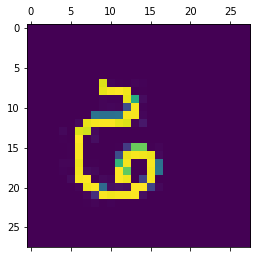

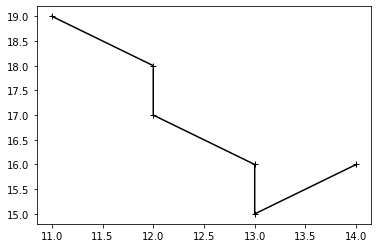

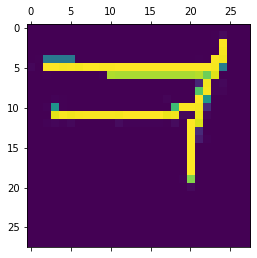

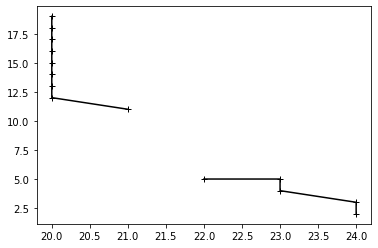

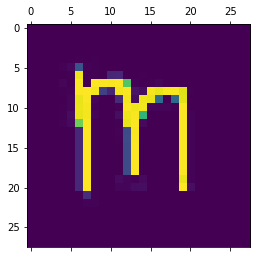

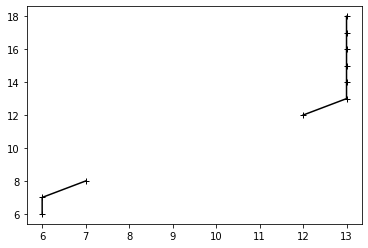

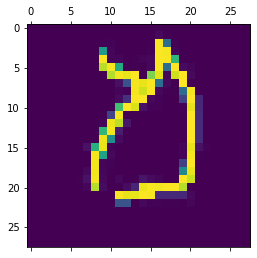

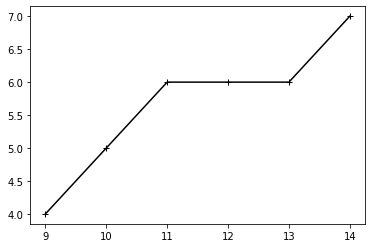

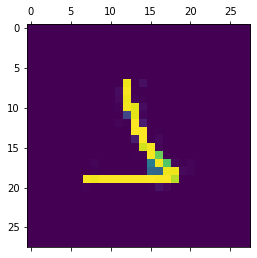

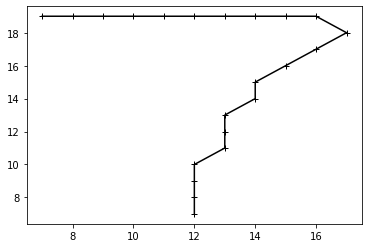

In [2]:
sbrain = sentive_brain(episode,5)

In [3]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(48)

{'_id': 48,
 'schema_version': 2,
 'type': 'sentive_vision_arcs',
 'layer_id': 2,
 'ratio_conn': 0.8999999999999999,
 'DbConnectivity': {'pre_synaptique': [1.0, 2.0, 3.0],
  'post_synaptique': [105],
  'lateral_connexion': [49, 48, 50],
  'weights': {50: 1, 48: 1, 49: 1, 105: 1},
  'angles': {50: 2.677945044588987, 49: 0.0}},
 'meta': {'center': {'x': 9, 'y': 7},
  'matrix_width': 3,
  'sub_pxl_map': array([[0., 0., 0.],
         [0., 1., 0.],
         [0., 2., 3.]]),
  'pxl_coord': [[10, 8], [9, 8], [9, 7]],
  'glbl_prm': {'cg': {'x': 9.333333333333334, 'y': 7.666666666666667},
   'u_axis': {'x': -0.7071067811865474, 'y': -0.7071067811865477}}}}

In [4]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(69)

{'_id': 69,
 'schema_version': 2,
 'type': 'sentive_vision_arcs',
 'layer_id': 2,
 'ratio_conn': 1.0,
 'DbConnectivity': {'pre_synaptique': [19.0, 27.0, 22.0],
  'post_synaptique': [116, 117, 118],
  'lateral_connexion': [66, 74, 69],
  'weights': {69: 1, 74: 1, 66: 1, 116: 1, 117: 1, 118: 1},
  'angles': {74: 0.0, 66: 0.0}},
 'meta': {'center': {'x': 6, 'y': 16},
  'matrix_width': 3,
  'sub_pxl_map': array([[ 0., 19.,  0.],
         [ 0., 22.,  0.],
         [ 0., 27.,  0.]]),
  'pxl_coord': [[6, 16], [6, 15], [6, 17]],
  'glbl_prm': {'cg': {'x': 6.0, 'y': 16.0}, 'u_axis': {'x': 0.0, 'y': 1.0}}}}

In [5]:
nrnx = sbrain.nnet[0].nrn_tls.get_neuron_from_id(74)

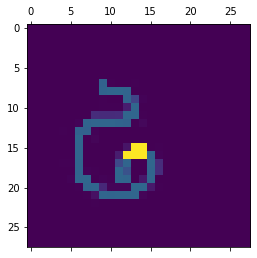

In [6]:
sbrain.nnet[0].show_receptive_field_id(67)

In [7]:
nrn_1 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(66)
vector_1 = nrn_1["meta"]["glbl_prm"]["u_axis"]
nrn_2 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(69)
vector_2 = nrn_2["meta"]["glbl_prm"]["u_axis"]
sbrain.nnet[0].nrn_tls.calc_angle(vector_1, vector_2)

0.0

In [8]:
nrn_1 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(60)
vector_1 = nrn_1["meta"]["glbl_prm"]["u_axis"]
nrn_2 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(59)
vector_2 = nrn_2["meta"]["glbl_prm"]["u_axis"]
sbrain.nnet[0].nrn_tls.calc_angle(vector_1, vector_2)

0.0

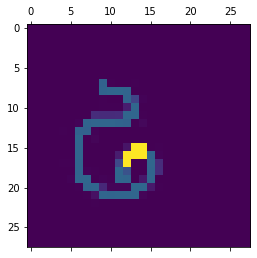

In [9]:
sbrain.nnet[0].show_receptive_field_id(71)

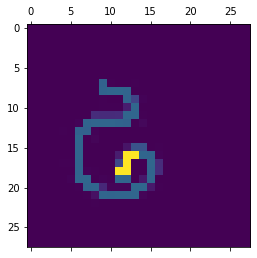

In [10]:
sbrain.nnet[0].show_receptive_field_id(75)

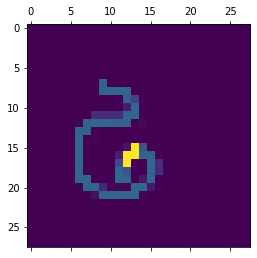

In [11]:
sbrain.nnet[0].show_receptive_field_id(70)

In [12]:
nrn_1 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(75)
vector_1 = nrn_1["meta"]["glbl_prm"]["u_axis"]
nrn_2 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(70)
vector_2 = nrn_2["meta"]["glbl_prm"]["u_axis"]
sbrain.nnet[0].nrn_tls.calc_angle(vector_1, vector_2)

3.141592653589793

In [13]:
np_c_1 = np.array([-0.52573111, 0.85065081])
np_c_2 = np.array([-0.52573111, 0.85065081])

In [14]:
np.arccos(np.sum(np.multiply(np_c_1,np_c_2))/(np.sqrt(np.sum(np.power(np_c_1,2)))*np.sqrt(np.sum(np.power(np_c_2,2)))))

0.0

47


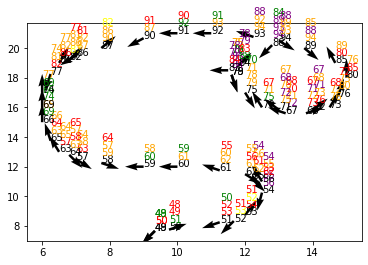

In [15]:
X = []
Y = []
u_x = []
u_y = []
nb = 0
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        nb += 1
        X.append(nrn2["meta"]["glbl_prm"]["cg"]["x"])
        Y.append(nrn2["meta"]["glbl_prm"]["cg"]["y"])
        u_x.append(nrn2["meta"]["glbl_prm"]["u_axis"]["x"])
        u_y.append(nrn2["meta"]["glbl_prm"]["u_axis"]["y"])
q = plt.quiver(X,Y,u_x,u_y)
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        x = nrn2["meta"]["glbl_prm"]["cg"]["x"]
        y = nrn2["meta"]["glbl_prm"]["cg"]["y"]
        plt.text(x,y, str(nrn2["_id"]))
        for key in nrn2["DbConnectivity"]['angles']:
            y += 0.5
            angle = nrn2["DbConnectivity"]['angles'][key]
            angle = np.abs(angle)
            if angle > (np.pi)/2:
                angle = np.pi - angle
            if angle ==0:
                color = "green"
            elif angle < 0.1:
                color = "yellow"
            elif angle < 0.4:
                color = "orange"
            elif angle < 0.8:
                color = "red"
            else :
                color = "purple"
            plt.text(x,y, str(key),color=color)
            
print(nb)

In [16]:
np.pi

3.141592653589793

(array([26., 30., 26., 26.,  8.,  4.,  4.,  8.,  6.,  4.]),
 array([0.        , 0.14781224, 0.29562447, 0.44343671, 0.59124894,
        0.73906118, 0.88687341, 1.03468565, 1.18249788, 1.33031012,
        1.47812235]),
 <BarContainer object of 10 artists>)

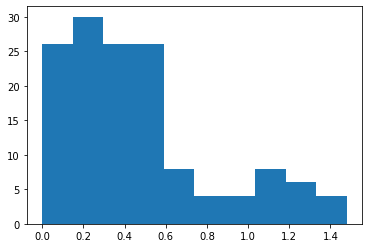

In [17]:
angles = []
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        for angle in nrn2["DbConnectivity"]['angles'].values():
            angle = np.abs(angle)
            if angle > (np.pi)/2:
                angle = np.pi - angle
            angles.append(angle)
            
plt.hist(angles)

In [18]:
for angle in nrnx["DbConnectivity"]['angles'].values():
    print(angle)

0.0
2.8198420991931514
